# Анализ, обучение и выбор моделей

In [296]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ShuffleSplit

import pandas as pd
import numpy as np
import random
import re

import matplotlib.pyplot as plt
import warnings

import pickle
import collections

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable

import scipy.sparse

In [297]:
MAX_DF = 0.8
MIN_COUNT = 5
TOKEN_RE = re.compile(r'[\w\d]+')

In [298]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

In [299]:
train = pd.read_csv('train_spam.csv')
test= pd.read_csv('test_spam.csv')

In [300]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Инвертирование меток классов
inverted_labels = ["ham" if label == "spam" else "spam" for label in train['text_type']]

train['text_type'] = label_encoder.fit_transform(inverted_labels)
train['text_type']

0        1
1        1
2        0
3        0
4        1
        ..
16273    0
16274    0
16275    1
16276    1
16277    1
Name: text_type, Length: 16278, dtype: int64

In [301]:
print('Количество обучающих текстов', len(train))
print('Количество тестовых текстов', len(test))
print()
print(train['text'][0].strip())

print()
print('Метка', train['text_type'][0])

Количество обучающих текстов 16278
Количество тестовых текстов 4070

make sure alex knows his birthday is over in fifteen minutes as far as youre concerned

Метка 1


In [302]:
def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

In [303]:
def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [304]:
train_tokenized = tokenize_corpus(train['text'])
test_tokenized = tokenize_corpus(test['text'])

print(' '.join(train_tokenized[0]))

make sure alex knows birthday over fifteen minutes youre concerned


In [305]:
def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

In [306]:
def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    if mode == 'bin':
        result = (result > 0).astype('float32')

    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))
        result = result.multiply(1 / word2freq)

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()

In [307]:
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 8586
[('this', 0), ('with', 1), ('have', 2), ('that', 3), ('your', 4), ('from', 5), ('will', 6), ('vince', 7), ('please', 8), ('subject', 9)]


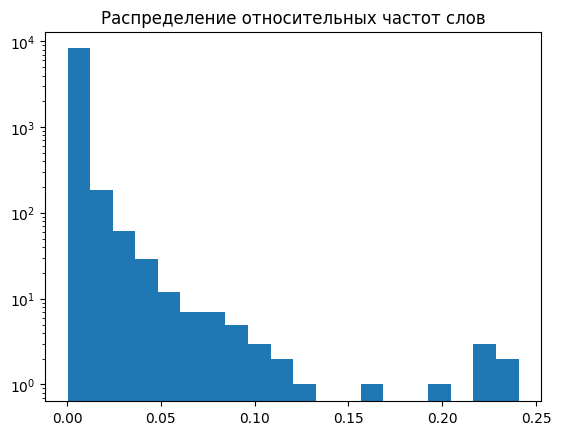

In [308]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [311]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)

Количество ненулевых элементов в обучающей выборке 364916
Количество ненулевых элементов в тестовой выборке 91236


In [12]:
nltk.download('punkt', quiet = True)
nltk.download('wordnet', quiet = True)

True

In [13]:
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [lemmatizer.lemmatize(token) for token in all_tokens if len(token) >= min_token_size]

## TF-IDF с логистической регрессией с использованием sklearn

In [14]:
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_and_lemmatize,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT,
                                                      stop_words = 'english')),
                             ('cls', LogisticRegression(n_jobs = -1))))

##### hold_out в sklearn реализации

##### Применение grid-search для поиска наилучших гиперпараметров

In [15]:
warnings.filterwarnings("ignore")

param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],
    'cls__C': [0.1, 1, 10, 15, 20]
}
X_train, X_local_test, y_train, y_local_test = train_test_split(train['text'], train['text_type'], test_size = 0.1, random_state = 42)
shuffle_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

grid_search = GridSearchCV(sklearn_pipeline, param_grid, cv = shuffle_split, scoring='roc_auc', verbose=0)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение ROC AUC:", grid_search.best_score_)

best_model_hold_out = grid_search.best_estimator_

Лучшие параметры: {'cls__C': 20, 'vect__max_df': 0.5, 'vect__min_df': 1}
Лучшее значение ROC AUC: 0.9748749391727493


In [17]:
#сохранение модели логистической регрессии с hold out разбиением
with open('1_logreg_holdout.pkl', 'wb') as f:
    pickle.dump(best_model_hold_out, f)

In [18]:
sklearn_train_pred = best_model_hold_out.predict_proba(X_train)
print('roc_auc на train', roc_auc_score(y_train, sklearn_train_pred[:, 1]))

sklearn_test_pred = best_model_hold_out.predict_proba(X_local_test)
print('roc_auc на val', roc_auc_score(y_local_test, sklearn_test_pred[:, 1]))

roc_auc на train 0.999464283929718
roc_auc на val 0.9770045810966528


##### График ROC-кривой на тренировочной выборке

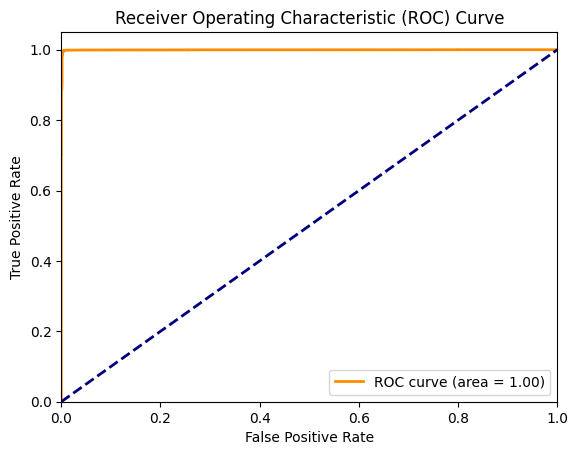

In [19]:
y_train_scores = sklearn_train_pred[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### График ROC-кривой на валидационной выборке

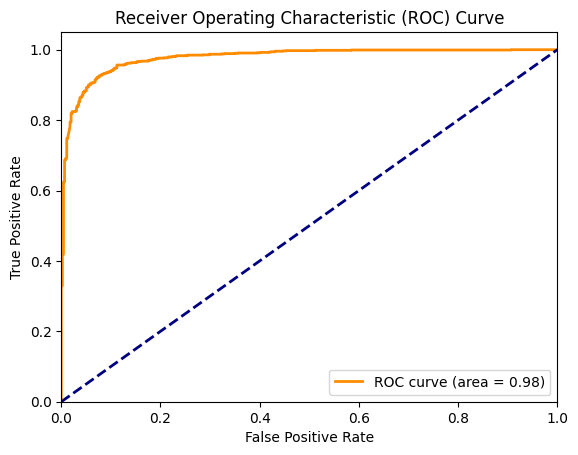

In [20]:
y_val_scores = sklearn_test_pred[:, 1]
fpr_val, tpr_val, thresholds_val = roc_curve(y_local_test, y_val_scores)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Использование KFold в sklearn реализации

In [21]:
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],
    'cls__C': [0.1, 1, 10, 15, 20]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_fold = GridSearchCV(estimator=sklearn_pipeline, param_grid=param_grid, cv=skf, scoring='roc_auc')

grid_search_fold.fit(X_train, y_train)

# Вывод лучших параметров и результатов
print("Лучшие параметры:", grid_search_fold.best_params_)
print("Лучший ROC AUC:", grid_search_fold.best_score_)

Лучшие параметры: {'cls__C': 20, 'vect__max_df': 0.5, 'vect__min_df': 1}
Лучший ROC AUC: 0.9774131685008995


In [22]:
best_model_fold = grid_search_fold.best_estimator_

#сохранение модели логистической регрессии с StratifiedKFold разбиением
# with open('2_logreg_strkfold.pkl', 'wb') as f:
#     pickle.dump(best_model_fold, f)

##### График roc_auc лучшей модели на train

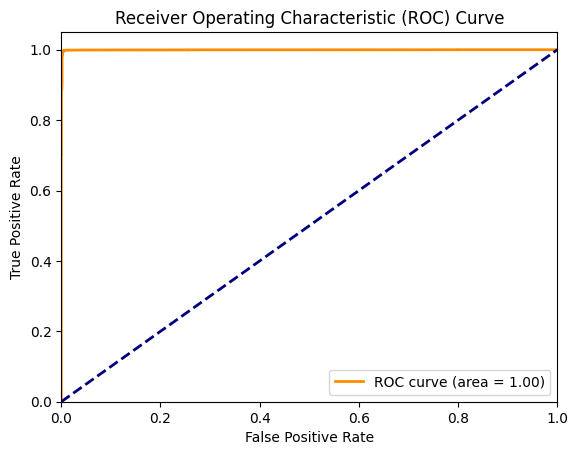

In [23]:
y_train_pred_proba_fold = best_model_fold.predict_proba(X_train)[:, 1]

fpr_train_fold, tpr_train_fold, thresholds_val_fold = roc_curve(y_train, y_train_pred_proba_fold)

roc_auc_train_fold = auc(fpr_train_fold, tpr_train_fold)

plt.figure()
plt.plot(fpr_train_fold, tpr_train_fold, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train_fold)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### График roc_auc лучшей модели на val

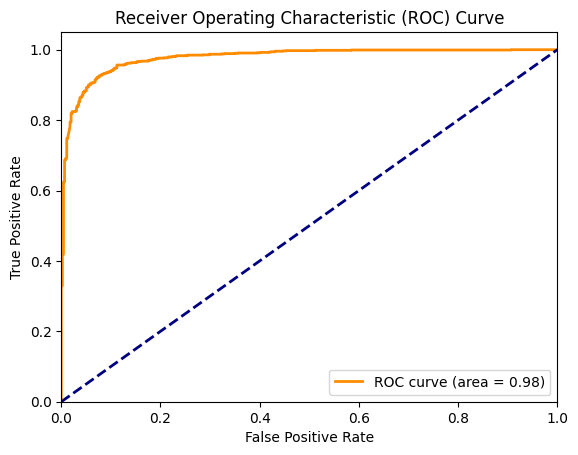

In [24]:
y_val_pred_proba_fold = best_model_fold.predict_proba(X_local_test)[:, 1]

fpr_val_fold, tpr_val_fold, thresholds_val_fold = roc_curve(y_local_test, y_val_pred_proba_fold)

roc_auc_val_fold = auc(fpr_val_fold, tpr_val_fold)

plt.figure()
plt.plot(fpr_val_fold, tpr_val_fold, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val_fold)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## TF-IDF с использованием Torch - Простая глубокая нейронная сеть

In [270]:
remove_non_alphabets_and_numbers =lambda x: re.sub(r'[^\w\d]+',' ',x)

In [271]:
tokenize = lambda x: word_tokenize(x)

In [272]:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

In [273]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [274]:
X_train_2 = train['text']
y_train_2 = train['text_type']

In [275]:
print('Processing : [=', end='')
X_train_2 = X_train_2.apply(remove_non_alphabets_and_numbers)
print('=', end='')
X_train_2 = X_train_2.apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
X_train_2 = X_train_2.apply(stem)
print('=', end='')
X_train_2 = X_train_2.apply(leammtizer)
print('=', end='')
X_train_2 = X_train_2.apply(lambda x: ' '.join(x))
print('] : Completed', end='')
X_train_2.head()

Processing : [=====] : Completed

0    make sure alex know hi birthday is over in fif...
1    a resum for john lavorato thank vinc i will ge...
2    plzz visit my websit moviesgodml to get all mo...
3    urgent your mobil number ha been award with a ...
4    overview of hr associ analyst project per davi...
Name: text, dtype: object

In [276]:
max_words = 18919
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(X_train_2).toarray()

In [277]:
sparse_matrix.shape

(16278, 18919)

In [278]:
x_train_3, x_local_test_3, y_train_3, y_local_test_3 = train_test_split(sparse_matrix, np.array(y_train_2), test_size = 0.1, random_state = 42)

In [279]:
class LogisticRegression_2(nn.Module):
    def __init__(self):
        super(LogisticRegression_2, self).__init__()
        self.linear1 = nn.Linear(18919, 250)
        self.linear2 = nn.Linear(250, 8)
        self.linear3 = nn.Linear(8, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [280]:
model = LogisticRegression_2()

In [281]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

In [282]:
x_train_3 = Variable(torch.from_numpy(x_train_3)).float()
y_train_3 = Variable(torch.from_numpy(y_train_3)).long()

Epoch: 1, Loss: 0.7550535202026367, Accuracy: 29.720136642456055%, ROC AUC: 0.4979639197886786
Epoch: 2, Loss: 0.5366241335868835, Accuracy: 67.5972671508789%, ROC AUC: 0.7620566286161141
Epoch: 3, Loss: 0.4361323118209839, Accuracy: 85.41979217529297%, ROC AUC: 0.8917187225065039
Epoch: 4, Loss: 0.3557593524456024, Accuracy: 92.33447265625%, ROC AUC: 0.9637195378754864
Epoch: 5, Loss: 0.3014189898967743, Accuracy: 95.05802154541016%, ROC AUC: 0.9852630956931601
Epoch: 6, Loss: 0.2635718882083893, Accuracy: 96.22525787353516%, ROC AUC: 0.9916656226945615
Epoch: 7, Loss: 0.2352142333984375, Accuracy: 97.02388763427734%, ROC AUC: 0.993335531920741
Epoch: 8, Loss: 0.2123238891363144, Accuracy: 97.65870666503906%, ROC AUC: 0.9944395101147513
Epoch: 9, Loss: 0.19100171327590942, Accuracy: 98.00682830810547%, ROC AUC: 0.9957032963463833
Epoch: 10, Loss: 0.1691049337387085, Accuracy: 98.30033874511719%, ROC AUC: 0.9967217602868729
Epoch: 11, Loss: 0.1456056535243988, Accuracy: 98.559730529785

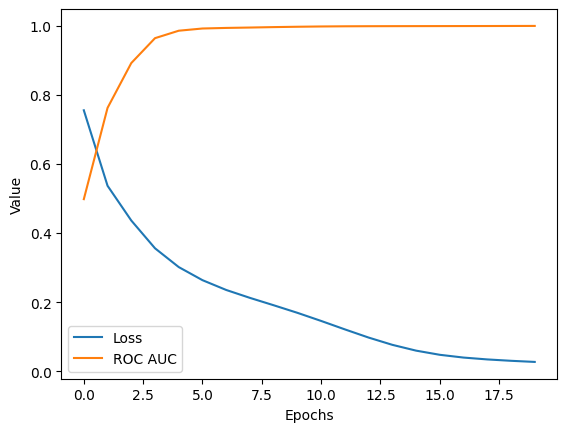

In [283]:
epochs = 20
model.train()
loss_values = []
roc_auc_values = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred_3 = model(x_train_3)
    loss = criterion(y_pred_3, y_train_3)
    loss_values.append(loss.item())
    
    probs_train = torch.softmax(y_pred_3, dim=1)[:, 1].detach().numpy()
    roc_auc = roc_auc_score(y_train_3.numpy(), probs_train)
    roc_auc_values.append(roc_auc)
    
    pred = torch.max(y_pred_3, 1)[1].eq(y_train_3).sum()
    acc = pred * 100.0 / len(x_train_3)
    
    print('Epoch: {}, Loss: {}, Accuracy: {}%, ROC AUC: {}'.format(epoch+1, loss.item(), acc.numpy(), roc_auc))
    
    loss.backward()
    optimizer.step()

plt.plot(loss_values, label='Loss')
plt.plot(roc_auc_values, label='ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

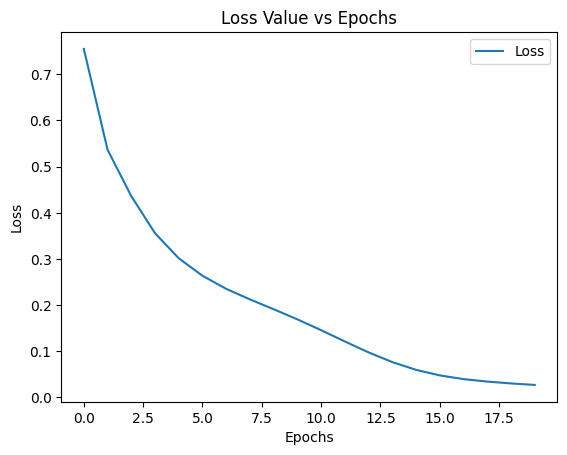

In [284]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [285]:
x_local_test_3 = Variable(torch.from_numpy(x_local_test_3)).float()
y_local_test_3 = Variable(torch.from_numpy(y_local_test_3)).long()

ROC-AUC для обучающего набора: 0.9992727105870193
ROC-AUC для тестового набора: 0.9793860018923958


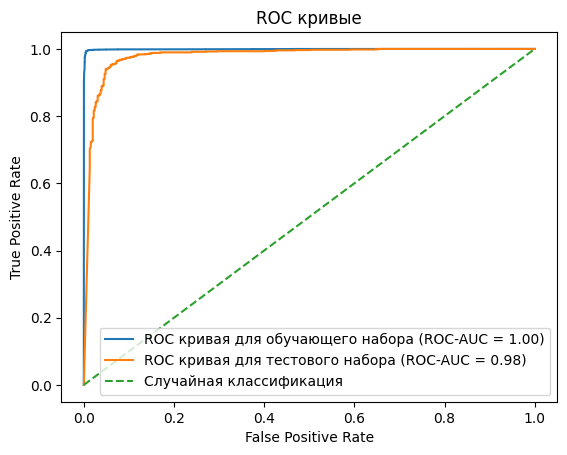

In [286]:
x_train_3 = x_train_3.view(x_train_3.size(0), -1)
model.eval()
with torch.no_grad():
    y_pred_train = model(x_train_3)
    probs_train = torch.softmax(y_pred_train, dim=1)[:, 1].numpy()

with torch.no_grad():
    y_pred_test = model(x_local_test_3)
    probs_test = torch.softmax(y_pred_test, dim=1)[:, 1].numpy()

auc_train = roc_auc_score(y_train_3.numpy(), probs_train)
auc_test = roc_auc_score(y_local_test_3.numpy(), probs_test)

print("ROC-AUC для обучающего набора:", auc_train)
print("ROC-AUC для тестового набора:", auc_test)

fpr_train, tpr_train, _ = roc_curve(y_train_3.numpy(), probs_train)
fpr_test, tpr_test, _ = roc_curve(y_local_test_3.numpy(), probs_test)

plt.plot(fpr_train, tpr_train, label='ROC кривая для обучающего набора (ROC-AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='ROC кривая для тестового набора (ROC-AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная классификация')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые')
plt.legend()
plt.show()

#### Приоритет отдается глубокой нейронной сети из-за более высокого показателя ROC-AUC

In [287]:
torch.save(model.state_dict(), '3_deepnet.pth')

## Получим результат работы модели на тестовой выборке

In [288]:
X_test_final = test['text']

In [289]:
print('Processing : [=', end='')
X_test_final = X_test_final.apply(remove_non_alphabets_and_numbers)
print('=', end='')
X_test_final = X_test_final.apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
X_test_final = X_test_final.apply(stem)
print('=', end='')
X_test_final = X_test_final.apply(leammtizer)
print('=', end='')
X_test_final = X_test_final.apply(lambda x: ' '.join(x))
print('] : Completed', end='')
X_test_final.head()

Processing : [=====] : Completed

0    j jim whitehead ejw cse ucsc edu write j you o...
1    origin messag from bitbitch magnesium net peop...
2    java for manag vinc durasoft who just taught t...
3                    there is a youtub name saiman say
4    underpr issu with high return on equiti the oi...
Name: text, dtype: object

In [290]:
X_test_sparse_matrix = cv.fit_transform(X_test_final).toarray()
X_test_final = Variable(torch.from_numpy(X_test_sparse_matrix)).float()

In [291]:
with torch.no_grad():
    y_pred_test_final = model(X_test_final)
    predicted_labels_final = torch.argmax(y_pred_test_final, dim=1).numpy()

In [292]:
predicted_labels_final_str = np.where(predicted_labels_final == 0, 'spam', 'ham')

In [293]:
test['score'] = predicted_labels_final_str
test = test.reindex(columns = ['score', 'text'])

In [294]:
test

,score,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you ...
1,ham,original message from bitbitch magnesium net p...
2,ham,java for managers vince durasoft who just taug...
3,ham,there is a youtuber name saiman says
4,ham,underpriced issue with high return on equity t...
...,...,...
4065,ham,husband to wifetum meri zindagi hoorwifeor kya...
4066,ham,baylor enron case study cindy yes i shall co a...
4067,ham,boring as compared to tp
4068,ham,hellogorgeous hows u my fone was on charge lst...


In [295]:
test.to_csv('scored_test.csv')